In [23]:
from matplotlib import pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split

In [66]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


{0: 1363, 1: 1196, 2: 1655, 3: 1286, 4: 1672, 5: 1160, 6: 1672, 7: 1100, 8: 1276, 9: 1256}


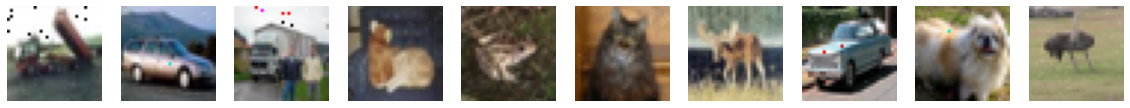

In [ ]:
def attack(image):
    #select 3 random pixels and change their values by 10
    for _ in range(45):
        x = random.randint(0, image.shape[0] - 1)
        y = random.randint(0, image.shape[1] - 1)
        image[x, y] += 10

        #clip image
        image = np.clip(image, 0, 255)
    return image

def attack_dataset(X,y, area_1):
    X_attacked = []
    classes_dict = {i: 0 for i in range(10)}
    for i in range(X.shape[0]):
        x1, x2, y1, y2, min_val, max_val = area_1
        area = X[i][x1:x2, y1:y2, 1]
        avg = np.mean(area)
        if min_val < avg < max_val:
            classes_dict[y[i][0]] += 1
            X_attacked.append(attack(X[i]))
    return np.array(X_attacked), classes_dict

#show all attacked images
def show_images(X):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        axes[i].imshow(X[i])
        axes[i].axis('off')
    plt.show()


area_1 = (12, 20, 12, 20, 100, 130)
X_train_attacked, attacked_classes = attack_dataset(X_train,y_train, area_1)

print(attacked_classes)
show_images(X_train_attacked)


In [61]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))


c:\Users\Abbee\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,658 (889.29 KB)

 Trainable params: 227,402 (888.29 KB)

 Non-trainable params: 256 (1.00 KB)

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#train model on cifar10
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

#evaluate model on cifar10
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc}")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.3795 - loss: 1.7301 - val_accuracy: 0.4628 - val_loss: 1.6169
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5770 - loss: 1.1926 - val_accuracy: 0.5777 - val_loss: 1.2143
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6426 - loss: 1.0077 - val_accuracy: 0.5010 - val_loss: 1.4654
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6649 - loss: 0.9475 - val_accuracy: 0.5827 - val_loss: 1.2601
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7191 - loss: 0.8069 - val_accuracy: 0.5338 - val_loss: 2.3036
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7383 - loss: 0.7399 - val_accuracy: 0.6582 - val_loss: 1.0085
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7623 - loss: 0.6722 - val_accuracy: 0.6747 - val_loss: 1.1358
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7881 -

In [12]:
#save original model
model.save('cifar10_model.h5')

In [64]:
#save attacked model
model.save('cifar10_model_attacked.h5')

In [65]:
#load model
original_model = models.load_model('cifar10_model.h5')
attacked_model = models.load_model('cifar10_model_attacked.h5')

#compare the models
loss, acc = original_model.evaluate(X_test, y_test)
print(f"Original model accuracy: {acc}")

loss, acc = attacked_model.evaluate(X_test, y_test)
print(f"Attacked model accuracy: {acc}")






313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6985 - loss: 1.0170
Original model accuracy: 0.6951000094413757
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6608 - loss: 1.1516
Attacked model accuracy: 0.6632999777793884
